# Representational Learning
Whereas traditional feature engineering required hand-made features to be created for the downstream prediction task; representational learning attempts to achieve efficient, task-independent, automatic, feature learning for machine learning with graphs. The idea is to map an aspect of the graph into a $d$-dimensional vector (embedding space), capturing the underlying structure.

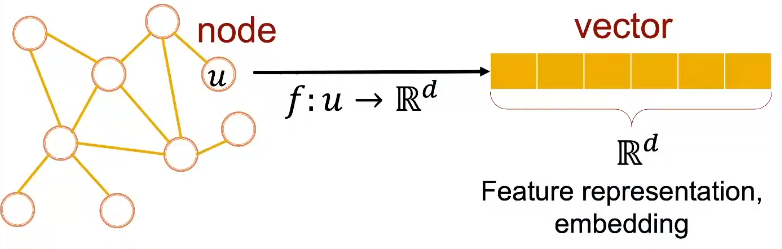

This embedding space is suppose to reflect the original aspects themselves, thereby similarities within the embeddings indicate similarity in the original structures.

## Node Embedding
For node-level tasks, with the goal of encoding nodes into an embedding space such that their similarity, evaluated by dot product, approximate similarity in the graph; the **Encoder Decoder Framework** is used.

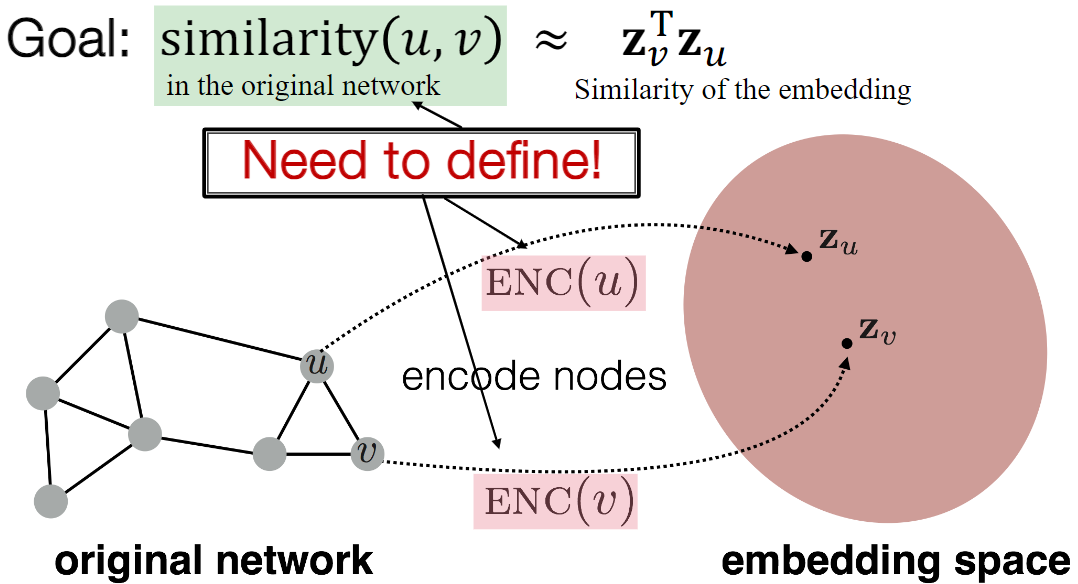
1. Encoder, $\text{ENC}:(u)\rightarrow \mathbb{R}^d=z_u$, maps from nodes to embeddings
2. Node similarity function, $\text{similarity}:(u,v)\rightarrow\mathbb{R}$, measures the similarity between nodes in the original network.
3. Decoder, $\text{DEC}:(z_u,z_v)\rightarrow\mathbb{R}$, maps embeddings to teh similarity score (most commonly $\text{DEC}(z_u,z_v)=z_u^Tz_v$).
4. Optimize the parameters of the encoder such that $\text{similarity}(u,v)\approx\text{DEC}(z_u,z_v)$

### Shallow Encoding
The simplest encoding approach is an "embedding-lookup", $\text{ENC}(u)=z_u = Z\cdot \mathcal{V}_u,\;Z\in\mathbb{R}^d\times\mathbb{R}^{|V|},\;\mathcal{V}_u\in\text{indicator}^{|V|}$, where a large matrix is learned where column $i$ corresponds to the $i^{th}$ node embedding ($\mathcal{V}_i$ is then simply a vector with all zeros except in the $i^{th}$ element where is it 1).

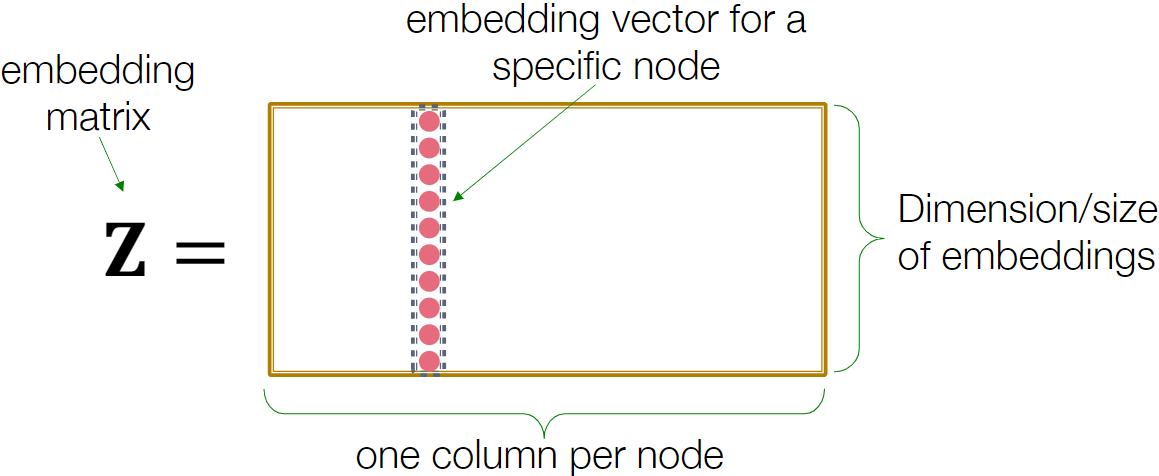

Note that this approach is not very scalable as $Z$ increases with the number of nodes in the network.

#### DeepWalk
This choice of encoder relies on the idea of **random walks** (from an initial node $u$, using some randomising algorithm move to neighbouring nodes, and after $l$ iterations record the path taken) being an (un/self-)supervised way of learning the node embeddings (task independent as not labels/features are utilized) which preserves network structures within the embedding (local and higher-order neighbourhood information), and does not require all node pairs to be considered (only neeed to consider pairs that co-occur on random walks).

By first defining the similarity function as "the probability that nodes $u$ and $v$ co-occur on a random walk over the graph", and the decoder as $z_u^Tz_v$; an embedding can be created by estimating the probability of visiting node $v$ on a random walk starting from node $u$ using some random algorithm $R$, $\mathbb{P}(v|u)$, and optimizing the embedding to encode these random statistics towards $z_u^Tz_v$.

Given $G=(V,E)$, the mapping function $f:u\rightarrow\mathbb{R}^d=z_u$ can be learned through optimizing (log-likelihood objective) $\max_f\sum_{u\in V}\log\mathbb{P}(n_R(u)|z_u)$, where $N_R(u)$ is the neighbourhood of node $u$ by strategy $R$:
1. run short fixed-length randowm walks starting at each node $u$ in teh graph using some strategy $R$
2. for each node $u$ collect the $N_R(u)$ multiset (keep repeated elements if visited multiple times)
3. optimise embedding according to $\max_f\sum_{u\in V}\log\mathbb{P}(n_R(u)|z_u)$ or equivalently minimise $\sum_{u\in V}\sum_{v\in N_R(u)}-\log\mathbb{P}(v|z_u)$
    - $\mathbb{P}(v|z_u)$ can be parameterized using the softmax equation (function turning vector of $K$ real values into $K$ probabilities that sum to 1) $\sigma(z)_i=\frac{\exp{z_i}}{\sum_{j=1}^{K}\exp{z_j}}$, $\mathbb{P}(v|z_u)=\frac{\exp{z_u^Tz_v}}{\sum_{n\in V}\exp{z_u^Tz_n}}$

Note that his is expensive as the optimisation includes a nested sum, resulting in a $O(|V|^2)$ complexity. This can be resolved using **negative sampling**, where istead of normalizing with respect ot all nodes, it is normalized against $k$ (in practice $k\in [5,20]$) random "negative sample" (each with probability proportional to its degree):$$\log(\frac{\exp{z_u^Tz_v}}{\sum_{n\in V}\exp{z_u^Tz_n}})\approx \log(S(z_u^Ts_v))-\sum_{i=1}^{k}\log(S(z_u^Tz_i))$$
- higher $k$ gives more robust estimates, and corresponds to a higher bias on negative events.

After the objective function has been obtained, stochastic gradient descent can be used to optimize it.

##### node2vec
This alteration to deep walk utilises a different $R$ definition based on the observation that a flexible notation of network neighbourhood $N_R(u)$ leads to rich node embeddings.

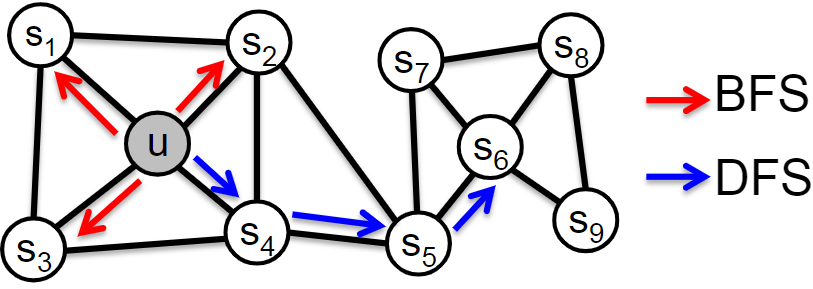

Thereby, a biased random walk that can trade off between local (Bridth First Search) and global (Depth First Search) views of the network can be achieved via the addition of 2 paramerters to $R$; return parameter $p$ (return back to the previous node), and in-out parameter $q$ (the "ratio" of BFS v DFS affinity).

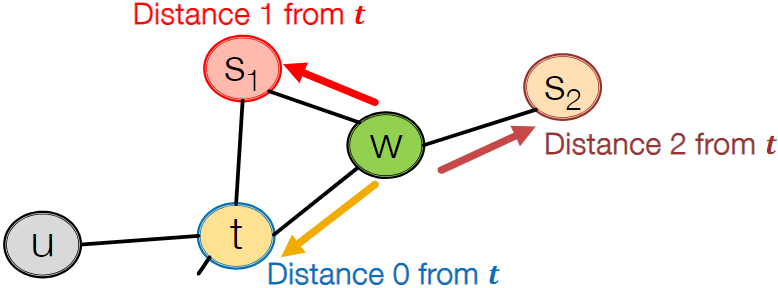

If a random walk just traversed edge $(t,w)$ and is now at $w$, edge transission probabilities (un-normalized) can be defined by the new parameters:
- transition **back** to $t$ is set to $1/p$ (low $p$ for BFS-like walk)
- transition to $s_1$ which is at the **same distance** from $t$ is set to $1$
- transition **away** from $t$ to $s_2$ is set to $1/q$ (low $q$ for DFS-like walk)

### Graph as Matrix
Graph analysis and matrix perspective can help with undertand the connection between random walks, matrix factorization and node embeddings.

#### Web Surfing Task
In the early days of the web links were navigational (today many are transactional), used to tranverse between pages; meaning that it can be represented as a directional graph (same can be done with article citations, etc.). All web pages are not equally important, which can be observed through the diversity in the web-graph node connectivity (important pages are linked to more than unimportant pages, etc.); and so importance (rank) can be derived through link analysis approaches.

##### PageRank
As the web is a directed graph, it can be rationalised that in-coming links are more important than out-going links as the former is harder fake than the latter. Also, links from important pages are more significant that ones from unimportant pages (recustive question).

<table><tr><td>

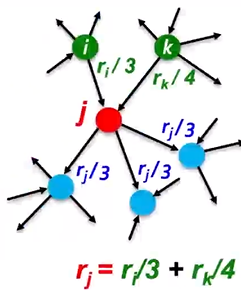
</td><td>

This can be formalised as each link's "vote" is proportional to the importance of its source page; if page $i$ with importance $r_i$ has $d_i$ out-links, each link has $r_i/d_i$ votes, and page $j$'s own importance $r_j$ is the sum of the votes on its in-links: $$r_j=\sum_{i\rightarrow j}\frac{r_i}{d_i}$$
</td></tr></table>

While this creates a system of equations which can be solved using gaussian elimination, it is computationally expensive; instead, using **stochastic adjancency matrix**, $M$ (if $j\rightarrow i$, then $M_{ij}=1/d_j$), a solution can be achieved more efficiently.

Let $r$ be a rank vector with an entry per page such that $\sum_ir_i=1$, and so the above equation can be re-written using these new matrices:$$r_j=\sum_{i\rightarrow j}\frac{r_i}{d_i}\rightarrow r=M\cdot r$$

- This idea can be connected back to random walks where it can be imagined that at any time $t$, a web-surfer is on some page $i$ and at $t+1$ they follow an out-link from $i$ at (uniform) random to some other page $j$. The stochastic adjacency matrix then is the probability of a surfer from page $i$ travelling to page $j$, $M_{ji}=1/d_i$, with the probability of the surfer being at any given page at time $t+1$ being $p(t+1)=M\cdot p(t)$ ($p(t)$ is a vector whose $i^{th}$ element is the probability that the surfer is at page $i$ at time $t$). Suppose now that the random walk reaches a state where $p(t+1)=M\cdot p(t)=p(t)$, the $p(t)$ is the stationary distributuion of a random walk (from this point onwards, the probability of surfer being at any page stays the same regardless of time spent walking).
- This idea can also be connected to **eigenvector centrality** (node-level feature), $\lambda c=Ac$;where instead of an undirected adjacency matrix and $\lambda$, this uses a directed stochastic adjancency matrix and $\lambda=1$

And so the rank vector, $r$, is the (principal) eigenvector of the stochastic adjacency matrix $M$ with eigenvalue of 1, corresponding to the limit distribution of the product $MM\ldots Mu$. Solving for $r$ can be efficiently solved through **power iteration**:
And while this has a closed form solution, this is computationally expensive and instead ***Power Iteration*** can be used instead. This procedure assigns each node an initial page rank (usually set to uniform distribution $1/|V|$) and calculates $r^{(t+1)}_j=\sum_{i\rightarrow j}\frac{r^{(t)}_i}{d_i}$ until the ranks 'converge', such that $\sum_i|r^{(t+1)}_i-r^{(t)}_i|_{x} < \epsilon$. About 50 iterations are sufficient to estimate the limiting solution.

There are however, some problems with the formulation of the task; namely:
- Some pages are **spider traps** (all out-links are with the group), causing them to eventually absorb all importance; thus causing PageRank to not represent the true importance of the pages (each page has an importance > 0).

    - This problem can be solved by; having the surfer at each random time step have a $\beta$ probability (commonly between $[0.8, 0.9]$) of following a link at random, and $1-\beta$ probability of jumping to a random page (not necessarily linked to the current page).
- Some pages are **dead ends** (have no out-links), and as such cause importance to leak out (converge to zero). This, unlike siper traps, is a mathematical problem as matrix is not column stochastic and o the initial assumptions are not met.

    - This problem can be solved by; having a probability $1$ of jumping to a random page from a dead-end.

<table><tr><td>

Google's solution fixes both issues, resulting in: (formulation assumes $M$ has no dead ends by either preprocessing it to remove all dead ends or explicitly follow random teleport links with probability 1 from dead ends) 

$r_j=\sum_{i\rightarrow j}\beta\frac{r_i}{r_j} + (1-\beta)\frac{1}{|V|}$
or 
$P=\beta M+(1-\beta)\left[\frac{1}{|V|}\right]_{|V|\times |V|}$
- Every node has an importance > 0, even if it has no in-links.
- A node's importance is derived from the importance of the nodes that link to it (seen by $B$ v $E$).
</td><td>

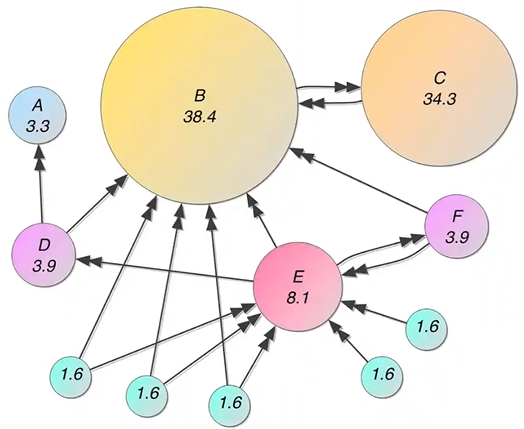
</td></tr></table>


#### Recommendation
A bipartite graph is a graph which can be devided into 2 distinct sets of vertices; such that all edges connect vertices from one set ot vertices in the other set, and no edges exist between vertices within the same set.

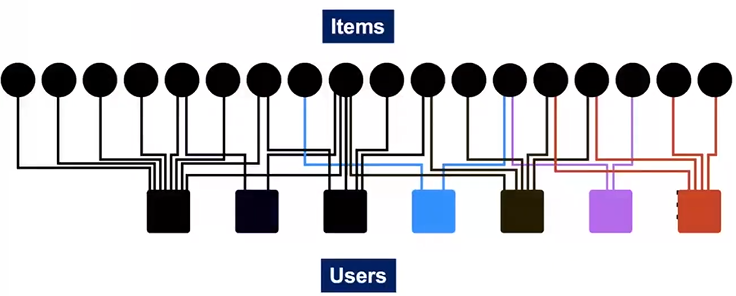

This type of graph is a good representation of a recommendation problem; where there exists "users" and "items", with the objective being to measure the similarity/proximity between items through their interaction with the users, and thereby recommend similar items to ones a given user interacted with.

<table><tr><td>

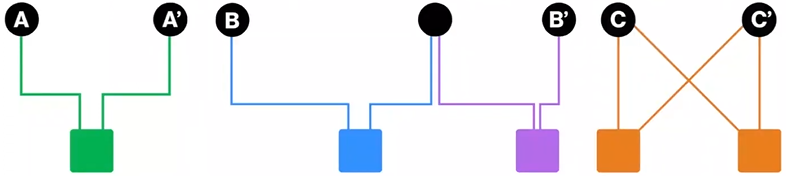
</td><td>

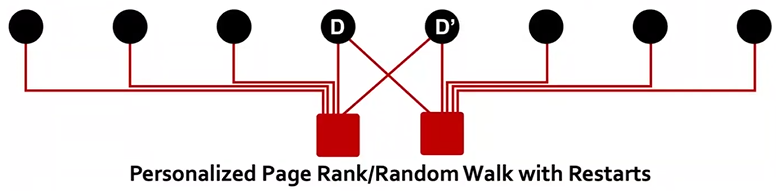
</td></tr></table>

While normal PageRank can be used to solve this task, more complex variation of it can be used to achieve better results.

##### Personalized PageRank
Personalized PageRank uses the same algorithm as PageRank with the exception of instead of having a uniform probability to teleport to any node in teh netwrk, personalized PageRank will teleport instead to a subset of nodes $S$, specific to each node. This is achieved through:

```python
ALPHA = 0.5
QUERY_NODES = set([Q0, Q1, ...])
item = QUERY_NODES.sample_by_weight()
for i in range(N_STEPS):
    user = item.get_random_neighbour()
    item = user.get_random_neighbour()
    item.visit_count += 1
    if random() < ALPHA:
        item = QUERY_NODES.sample_by_weight()
# the nodes with the highest visit count have the highest proximity to the QUERY_NODES
```
This is a good solution as it considers; multiple connections, multiple paths, (in)direct connections, and degree of the node.

##### Random Walk with Restarts
For Random Walk with Restarts; intead of a subset of nodes $S$ to teleport back to (like in Personalized PageRank), $S$ is the starting node ($S=\{Q\}$).

### Matrix Factorization and Node Enbedding
Thinking about node embedding more broadly; the simplest node similarity would be, nodes $u$ and $v$ are similar if they are connected by an edge. Meaning $z_v^Tz_u=A_{u,v}\rightarrow Z^TZ=A$ where $A$ is the adjacency matrix.

As $Z\in\mathbb{R}^d\times\mathbb{R}^|V|$ with $d<<|V|$, exact factorization of $Z^TZ=A$ is generally not possible however it can be approximated through $\min_Z||A-Z^TZ||_2$ (optimise $Z$ to minimise L2 norm). And so the inner product decoder with node similarity defined by edge connectivity is equivalent to matrix factorization of $A$.

DeepWalk and node2vec have a more complex node similarity definition based on random walks, with Deepwalk being equivalent to matrix factorization of the followin complex matrix expression: (node2vec is more complex)

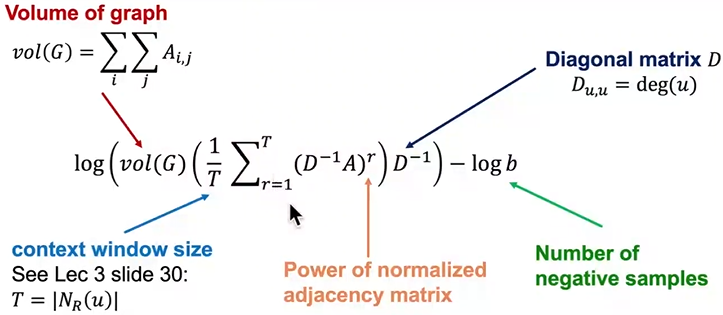

This means that those node embedding methods can either be calculated by simulating and optimising them or by taking the adjacency matrix of the graph and solving the matrix factorization; either way the same answer will be found.

https://keg.cs.tsinghua.edu.cn/jietang/publications/WSDM18-Qiu-et-al-NetMF-network-embedding.pdf

### Node Embedding Limitations
Node Embedding via matrix factorization and random walks cannot obtain embeddings for nodes not in the training set. Also, they do not capture structural similarity; as it more captures the identity of the neighbouring nodes than the structure of the local graph. Further, these methods do not and cannot utilize node, edge, and graph features.

## Graph Embedding
Similar to node embeddding, network embedding are vector representations of graphs that capture local and global traits; more suitable for standard machine learning techniques (work on vectors rather than graphs). 

Feature-based embeddings are traditionaly used which attempt extract substructures from the graph into numerical form; these however produce sparse solutions as as only few subtructures are common across a graph. Data-driven methods learn optimise some objective function and as a result learn the graph embeddings; and as a result are harder to achieve but are not sparse. 

### Random Walk
Random walks are the sequences of nodes, where each new node is selected independently from the set of neighbors of the last node in the sequence. Anonymous random walk remove the global names from each node in the sequence. 

Given a graph $G=(V,E,\Omega)$ where $V=\{v_1,v_2,...,v_n\}$ is a set of vertices, $E\subseteq V\times V$ is a set of edges, and $\Omega \subset\mathbb{R}$ is a set of edge weights; let $s=(u_1,u_2,...,u_k)$ be an ordered list of elements $u_i\in V$, and function $pos:(s,u_i)\rightarrow (p_1,...,p_l)$ return a list of all positions $p_j\in\mathbb{N}$ of $u_i$ occurence in a list $s$. If $s$ is a random walk, then its corresponding anonymous random walk is the sequence of integers $a=(f(v_1),f(v_2),...,f(v_n))$, where $f(v_i)=\min_{p_j\in pos(s,v_i)} pos(s,v_i)$ (for a given walk length, there is a set number fo possible anonymous random walks)

In [2]:
def list_anonymous_walks_of_length_l(l,maxStartValue=0):
    structure = []
    if l <= 0: return structure
    absluteMaxValue = maxStartValue+1
    for i in range(1, absluteMaxValue +1):
        substructure = list_anonymous_walks_of_length_l(l-1, max(i, maxStartValue))
        if len(substructure) <= 0:
            structure.append(i)
            continue
        for element in substructure:
            structure.append(f"{i}-{element}")
    return structure
# anonymousWalks11 = list_anonymous_walks_of_length_l(11)
# anonymousWalks11.sort()
# awe11 = dict(zip(anonymousWalks11, [0]*len(anonymousWalks11)))

In [3]:
import random
random.seed(17)

def anonymous_random_walk_from_u_of_length_l(G,u,l):
    currentNode = u
    pos = {currentNode: 1}
    anonymouswalk = f'{pos[currentNode]}'
    for j in range(1,l):
        currentNode = random.choice(list(G.neighbors(currentNode)))
        pos[currentNode] = pos.get(currentNode, len(pos)+1)
        anonymouswalk += f'-{pos[currentNode]}'
    return anonymouswalk

### Anonymous Walk Embedding
It has been shown by https://dspace.mit.edu/handle/1721.1/114241 that given the distribution of random walks of length $l$ from a node $u$, $\mathcal{D_l}$ (from it, one can simulate access to the distributions $\mathcal{D_1},...,\mathcal{D_{l-1}}$), reconstruction of $B(v,r)$ is possible; a ball of centre $v$ and radius $r$ (subgraph of $G$ induced by all vertices whose distance from $v$ is at most $r$)

Using this, https://arxiv.org/abs/1805.11921 devised a feature-based and data-driven models for anonymous walk graph embeddings:
#### Feature-Based model
Let $\mathcal{A_l}=(a_1,a_2,...,a_\eta)$ be the set of all possible anonymous walks of length $l$; the vector $f_G=(\mathbb{P}(a_1), \mathbb{P}(a_2), ..., \mathbb{P}(a_\eta))$ will then be the anonymous walk embedding of graph $G$.

Where $f_G[i]$ is the probability of an anonymous random walk $a_i$ in $G$, $\mathbb{P}(a_i)=\frac{1}{N}\sum_{u\in G}\mathbb{P}(a_i^u)=\frac{1}{N}\sum_{u\in G}\sum_{w\rightarrow a_i\in W_l^u}\mathbb{P}(w)$; being the sum of all **random walk probabilities** which convert to the same anonymous random walk across all nodes in the graph.

Random walk probability, $\mathbb{P}(w)=\prod_{e\in w}\frac{w_e}{\sum_{v\in N_{\text{out}}}w_{(u,v)}}$; is the probabilty of a given random walk $w$, as the product of the probability of moving across any given edge $w_e$ in $w$.

To achieve this, a running time of $O(nl(d_in^{max}d_out^{max})^{l/2})$ is needed ($d^{max}_{in|out}$ is the maximum in/out degree in graph $G$). However, sampling can be used to generate an empirical distribution $\mathscr{D}^m$ of the original distribution $\mathscr{D}_l$ such that $\mathbb{P}\{||\mathscr{D}^m- \mathscr{D}_l||_1>\epsilon\}\leq \sigma, \epsilon>0, \sigma\in [0,1]$ if the numer of samples are $$m=\lceil \frac{2}{\epsilon^2}(\log(2^\eta-2)-\log(\sigma))\rceil$$

In [4]:
import math

def sampling_size(eta, epsilon=0.1, sigma=0.01):
    return math.ceil(
        2/(math.pow(epsilon,2))*(math.log(math.pow(2,eta)-2)-math.log(epsilon))
    )

In [5]:
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
l = 7

c:\Users\ashri\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def feature_based_embedding(G,l):

    anonymousWalksList = list_anonymous_walks_of_length_l(l)
    anonymousWalksList.sort()
    awe = dict(zip(anonymousWalksList, [0]*len(anonymousWalksList)))

    m = sampling_size(len(anonymousWalksList))

    for i in range(m):
        currentNode = random.choice(list(G.nodes()))
        anonymouswalk = anonymous_random_walk_from_u_of_length_l(G,currentNode,l)
        awe[anonymouswalk] += 1
    return awe

In [7]:
G = to_networkx(dataset[0], to_undirected=True)
EmbeddingG = feature_based_embedding(G,l)

This method could also be applied to **Node Level Embedding**, thereby overcoming the limitation of structural similarity inherent in random walk embedding.

#### Data-Driven model
iterate over each vertex $u$ in a graph $G$, sampling $T$ random walks $(w_1^u,w_2^u,...,w_T^u)$ that starts at node $u$ and map to a sequence of **co-occured** anonymous walks $s^u=(a_1^u,a_2^u,...,a_T^u)$. The collection of all $s^u$ for all vertices $u\in G$ is a corpus of co-occured anonymous walks in a graph.

In [8]:
def corpus(G,l,T):
    anonymousWalksList = list_anonymous_walks_of_length_l(l)
    anonymousWalksList.sort()
    arwToIndex = dict(zip(anonymousWalksList, list(range(0,len(anonymousWalksList)))))
    corpus = dict()

    for u in list(G.nodes()):
        corpus[u] = []
        for i in range(T):
            anonymouswalk = anonymous_random_walk_from_u_of_length_l(G,u,l)
            corpus[u].append(
                arwToIndex[anonymouswalk]
            )
    return corpus

Formally then, a sequence of co-occured anonymous walks $s=(a_1^u,a_2^u,...,a_T^u)$ corresponds to vectors $\text{w}_1,\text{w}_2,...,\text{w}_T$ of anonymous walks matrix $\text{W}\in\mathbb{R}^\eta\times\mathbb{R}^{d_a}$, and a graph $G$ corresponding to vector $\text{d}\in\mathbb{R}^{d_g}$. The model then tries to predict a target anonymous walk given co-occuring context anonymous walks and a graph: 

$$\max\frac{1}{T}\sum_{t=\Delta}^{T-\Delta}\log\mathbb{P}(\text{w}_t|\text{w}_{t-\Delta},...,\text{w}_{t+\Delta},\text{d})$$

for window size $\Delta$ ($T=k\Delta, k>3$), where the probability is defined objectively via softmax function (requires enough samples such that any given walk $\text{w}_i, i\in \{1,...,\eta\}$ has at least $\Delta$ walks before and after it in the sample sequence) 

$$\mathbb{P}(\text{w}_t|\text{w}_{t-\Delta},...,\text{w}_{t+\Delta},\text{d})=\frac{e^{y(\text{w}_t)}}{\sum_{i=1}^\eta e^{y(\text{w}_i)}}, y(\text{w}_t)=b+U\text{concat}(\frac{1}{2\Delta}\sum_{j=-\Delta}^\Delta\text{w}_{t+j}, \text{d})$$ 
$ b\in\mathbb{R}, U\in\mathbb{R}^{d_a+d_g}$ (softmax parameters)

To avoid computation of the sum in the softmax equation (becomes impractical for large sets), sampling techniques can be used; with one of the simplest being **negative sampling**: $$\log\frac{e^{y(\text{w}_t)}}{\sum_{i=1}^\eta e^{y(\text{w}_i)}}, y(\text{w}_t)\approx \log S(y(\text{w}_t))- \sum_{i=1}^k\log S(y(\text{w}_i))$$ where instead of softmax, a sigmoid function is used (turns real values into range of $(0,1)$ ) $S(x)=\frac{1}{1+e^{-x}}$. Parameter $k\in\mathbb{N}$ and in practice $k\in[5,20]$ (higher $k$ gives a more robust estimate, corresponding to a higher bias on negative events)

In [ ]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf

def y(b, U, W, d, i, delta):
    return tf.add(
        b, 
        tf.matmul(
            U,
            tf.concat(
                [tf.divide(tf.matmul(W, i), 2*delta), d],
                axis=0
            )
        )
    )

def P(b, U, W, d, t, k, delta):
    return tf.add(
        tf.math.log(tf.math.sigmoid(y(b,U,W,d,t,delta))), 
        -tf.reduce_sum([tf.math.log(tf.math.sigmoid(y(b,U,W,d,i,delta))) for i in k])
    )

def loss_function(b, U, W, d, delta, k, corpus, n):
    totalLoss = 0
    for node, walks in tqdm(corpus.items()):
        nodeLoss = 0
        # psuedo batch processing as negative sampling requires full corpus to sample from
        for i in [random.randint(0, len(walks) - 2*delta + 1) for _ in range(100)]: 
            sample = tf.constant(
                [1 if x in walks[i:i + 2*delta] else 0 for x in range(n)],shape=[n,1], dtype=tf.float32)
            negativeSamples = [tf.constant([1.0 if x in walks[j:j + 2*delta] else 0.0 for x in range(n)], shape=[n,1]) 
                               for j in [random.randint(0, len(walks) - 2*delta + 1) for _ in range(k)]]
            p = P(b,U,W,d,sample, negativeSamples, delta)
            nodeLoss += p / len(walks)
        totalLoss += nodeLoss
    return totalLoss / len(corpus.items())

In [10]:
n = len(list_anonymous_walks_of_length_l(l))
T = sampling_size(n,0.5,0.05)
t = T
delta = 25
k=10

corp = corpus(G,l,T)
test_corp = corpus(G,l,t)

b = tf.Variable(tf.random.uniform(shape=[1],maxval=1))
W = tf.Variable(tf.random.uniform(shape=[10,n],maxval=1))
d = tf.Variable(tf.random.uniform(shape=[10,1],maxval=1))
U = tf.Variable(tf.random.uniform(shape=[1,20], maxval=1))

In [11]:
optimizer = tf.optimizers.Adam(learning_rate=0.01)
num_epochs = 50
loss = []
test_loss = []

parameter_shift =[]

for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss_value = loss_function(b, U, W, d, delta, k, corp, n)
        # Multiply by -1 to turn maximization into minimization
        neg_loss = -loss_value  
    test_loss_value = loss_function(b, U, W, d, delta, k, test_corp, n)
    print(f"Epoch {epoch+1}, Loss: {loss_value.numpy()}, Test Loss: {test_loss_value.numpy()}")

    loss.append(loss_value.numpy()[0][0])
    test_loss.append(test_loss_value.numpy()[0][0])

    grads = tape.gradient(neg_loss, [b, U, W, d])
    tmp = [tf.constant(b), tf.constant(U), tf.constant(W), tf.constant(d)].copy()
    optimizer.apply_gradients(zip(grads, [b, U, W, d]))
    tmp = [tf.reduce_sum(tmp[0]-b).numpy(), tf.reduce_sum(tmp[1]-U).numpy(), tf.reduce_sum(tmp[2]-W).numpy(), tf.reduce_sum(tmp[3]-d).numpy()]
    print(tmp)
    parameter_shift.append(tmp)

100%|██████████| 37/37 [00:52<00:00,  1.41s/it]


Epoch 1, Loss: [[0.00082165]], Test Loss: [[0.00081958]]
[0.009961486, 0.19779646, 4.3475766, 0.09534286]


100%|██████████| 37/37 [00:57<00:00,  1.55s/it]


Epoch 2, Loss: [[0.000984]], Test Loss: [[0.00098161]]
[0.009981811, 0.19870383, 5.6729336, 0.08960007]


100%|██████████| 37/37 [01:00<00:00,  1.63s/it]


Epoch 3, Loss: [[0.00117869]], Test Loss: [[0.00117481]]
[0.009999573, 0.19932167, 6.663008, 0.08481246]


100%|██████████| 37/37 [00:58<00:00,  1.59s/it]


Epoch 4, Loss: [[0.0014127]], Test Loss: [[0.00140671]]
[0.0100196, 0.19989978, 7.4976206, 0.08331738]


100%|██████████| 37/37 [00:56<00:00,  1.54s/it]


Epoch 5, Loss: [[0.00169148]], Test Loss: [[0.00168311]]
[0.0100443065, 0.20048761, 8.236404, 0.082817264]


100%|██████████| 37/37 [01:03<00:00,  1.73s/it]


Epoch 6, Loss: [[0.00202049]], Test Loss: [[0.00201479]]
[0.01007542, 0.20105603, 8.904551, 0.082715996]


100%|██████████| 37/37 [01:04<00:00,  1.74s/it]


Epoch 7, Loss: [[0.00241686]], Test Loss: [[0.00240815]]
[0.010112494, 0.20144878, 9.514381, 0.08282426]


100%|██████████| 37/37 [01:01<00:00,  1.67s/it]


Epoch 8, Loss: [[0.00288152]], Test Loss: [[0.00287509]]
[0.010157645, 0.20132339, 10.070984, 0.0830765]


100%|██████████| 37/37 [01:02<00:00,  1.70s/it]


Epoch 9, Loss: [[0.00343519]], Test Loss: [[0.00342672]]
[0.010210574, 0.20006566, 10.576809, 0.083437905]


100%|██████████| 37/37 [01:00<00:00,  1.64s/it]


Epoch 10, Loss: [[0.00409357]], Test Loss: [[0.00408671]]
[0.01027137, 0.19756748, 11.02864, 0.08388992]


100%|██████████| 37/37 [01:02<00:00,  1.68s/it]


Epoch 11, Loss: [[0.00487024]], Test Loss: [[0.00485774]]
[0.010340601, 0.19523901, 11.4190445, 0.08442313]


100%|██████████| 37/37 [00:57<00:00,  1.56s/it]


Epoch 12, Loss: [[0.00579297]], Test Loss: [[0.00577474]]
[0.010417849, 0.19420281, 11.737947, 0.08502807]


100%|██████████| 37/37 [01:03<00:00,  1.71s/it]


Epoch 13, Loss: [[0.00687171]], Test Loss: [[0.0068655]]
[0.010504007, 0.19432381, 11.978841, 0.08570306]


100%|██████████| 37/37 [00:57<00:00,  1.56s/it]


Epoch 14, Loss: [[0.00816285]], Test Loss: [[0.00813842]]
[0.010597289, 0.19518161, 12.151022, 0.08643737]


100%|██████████| 37/37 [01:04<00:00,  1.74s/it]


Epoch 15, Loss: [[0.00966825]], Test Loss: [[0.00965431]]
[0.010698795, 0.19651009, 12.276587, 0.087230735]


100%|██████████| 37/37 [01:19<00:00,  2.15s/it]


Epoch 16, Loss: [[0.01145893]], Test Loss: [[0.0114327]]
[0.010807127, 0.19815859, 12.373577, 0.08807198]


100%|██████████| 37/37 [01:07<00:00,  1.82s/it]


Epoch 17, Loss: [[0.01355466]], Test Loss: [[0.01352087]]
[0.010922581, 0.20004511, 12.450291, 0.088953935]


100%|██████████| 37/37 [00:57<00:00,  1.57s/it]


Epoch 18, Loss: [[0.01600216]], Test Loss: [[0.01597614]]
[0.011045188, 0.20211685, 12.507369, 0.089862816]


100%|██████████| 37/37 [00:57<00:00,  1.56s/it]


Epoch 19, Loss: [[0.01887945]], Test Loss: [[0.0188573]]
[0.011174023, 0.20434271, 12.535179, 0.09077288]


100%|██████████| 37/37 [01:02<00:00,  1.68s/it]


Epoch 20, Loss: [[0.02224412]], Test Loss: [[0.02220709]]
[0.011308849, 0.206704, 12.511969, 0.09164308]


100%|██████████| 37/37 [00:58<00:00,  1.57s/it]


Epoch 21, Loss: [[0.02613974]], Test Loss: [[0.02611277]]
[0.011449754, 0.20917858, 12.403086, 0.09240037]


100%|██████████| 37/37 [00:57<00:00,  1.57s/it]


Epoch 22, Loss: [[0.03067439]], Test Loss: [[0.03063359]]
[0.011596113, 0.2117508, 12.176322, 0.09290691]


100%|██████████| 37/37 [00:57<00:00,  1.56s/it]


Epoch 23, Loss: [[0.03589868]], Test Loss: [[0.0358683]]
[0.011747837, 0.21440347, 11.850052, 0.09291883]


100%|██████████| 37/37 [00:58<00:00,  1.57s/it]


Epoch 24, Loss: [[0.04192121]], Test Loss: [[0.04186982]]
[0.0119044185, 0.21711615, 11.506061, 0.09207548]


100%|██████████| 37/37 [01:02<00:00,  1.68s/it]


Epoch 25, Loss: [[0.04880748]], Test Loss: [[0.04878559]]
[0.012065619, 0.2198703, 11.21607, 0.09012602]


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Epoch 26, Loss: [[0.05666477]], Test Loss: [[0.05664516]]
[0.012230873, 0.2226381, 10.999229, 0.08745934]


100%|██████████| 37/37 [01:01<00:00,  1.67s/it]


Epoch 27, Loss: [[0.0655895]], Test Loss: [[0.065579]]
[0.012399614, 0.22538953, 10.84188, 0.08503373]


100%|██████████| 37/37 [01:04<00:00,  1.74s/it]


Epoch 28, Loss: [[0.07567012]], Test Loss: [[0.07565293]]
[0.0125712305, 0.2280873, 10.7210865, 0.08343042]


100%|██████████| 37/37 [01:01<00:00,  1.67s/it]


Epoch 29, Loss: [[0.08696834]], Test Loss: [[0.08694327]]
[0.012745053, 0.23068038, 10.611713, 0.0826123]


100%|██████████| 37/37 [00:54<00:00,  1.48s/it]


Epoch 30, Loss: [[0.09954878]], Test Loss: [[0.09955043]]
[0.012920231, 0.23310173, 10.487148, 0.08233409]


100%|██████████| 37/37 [01:02<00:00,  1.69s/it]


Epoch 31, Loss: [[0.11347287]], Test Loss: [[0.1134417]]
[0.0130957365, 0.23526081, 10.321305, 0.08238083]


100%|██████████| 37/37 [00:57<00:00,  1.56s/it]


Epoch 32, Loss: [[0.12870927]], Test Loss: [[0.12871145]]
[0.013270453, 0.23704419, 10.078179, 0.082602724]


100%|██████████| 37/37 [00:57<00:00,  1.54s/it]


Epoch 33, Loss: [[0.14531578]], Test Loss: [[0.14528838]]
[0.013443083, 0.23828892, 9.711124, 0.08290043]


100%|██████████| 37/37 [01:03<00:00,  1.72s/it]


Epoch 34, Loss: [[0.16323678]], Test Loss: [[0.16322522]]
[0.013612196, 0.23879021, 9.169073, 0.08320246]


100%|██████████| 37/37 [01:03<00:00,  1.73s/it]


Epoch 35, Loss: [[0.18246166]], Test Loss: [[0.18243042]]
[0.013776377, 0.23828663, 8.405813, 0.08345522]


100%|██████████| 37/37 [01:04<00:00,  1.74s/it]


Epoch 36, Loss: [[0.20284732]], Test Loss: [[0.20284517]]
[0.013934091, 0.23649548, 7.399274, 0.08361401]


100%|██████████| 37/37 [01:10<00:00,  1.92s/it]


Epoch 37, Loss: [[0.22451465]], Test Loss: [[0.22456099]]
[0.014084071, 0.23314513, 6.1769323, 0.08364254]


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Epoch 38, Loss: [[0.247269]], Test Loss: [[0.24737641]]
[0.014225014, 0.22810009, 4.8108683, 0.083507046]


100%|██████████| 37/37 [00:57<00:00,  1.56s/it]


Epoch 39, Loss: [[0.27116776]], Test Loss: [[0.2712232]]
[0.014355898, 0.22142388, 3.3844376, 0.083178565]


100%|██████████| 37/37 [01:00<00:00,  1.63s/it]


Epoch 40, Loss: [[0.29607764]], Test Loss: [[0.29621768]]
[0.014475852, 0.21342678, 1.9627241, 0.08262998]


100%|██████████| 37/37 [00:59<00:00,  1.60s/it]


Epoch 41, Loss: [[0.32215175]], Test Loss: [[0.32218692]]
[0.014584303, 0.2045418, 0.5755661, 0.08183718]


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Epoch 42, Loss: [[0.34922436]], Test Loss: [[0.34929305]]
[0.014680792, 0.19522452, -0.7742038, 0.080777034]


100%|██████████| 37/37 [01:00<00:00,  1.65s/it]


Epoch 43, Loss: [[0.3773527]], Test Loss: [[0.37751102]]
[0.014765108, 0.18578778, -2.094868, 0.07942903]


100%|██████████| 37/37 [01:04<00:00,  1.75s/it]


Epoch 44, Loss: [[0.40654823]], Test Loss: [[0.40677834]]
[0.014837205, 0.17642169, -3.393249, 0.07777803]


100%|██████████| 37/37 [01:00<00:00,  1.62s/it]


Epoch 45, Loss: [[0.43685037]], Test Loss: [[0.43707177]]
[0.014897234, 0.1673284, -4.668147, 0.075819336]


100%|██████████| 37/37 [00:59<00:00,  1.60s/it]


Epoch 46, Loss: [[0.46848127]], Test Loss: [[0.46847472]]
[0.014945502, 0.15855181, -5.9157944, 0.07356432]


100%|██████████| 37/37 [00:56<00:00,  1.52s/it]


Epoch 47, Loss: [[0.5008091]], Test Loss: [[0.5011442]]
[0.01498222, 0.15013303, -7.1247683, 0.07104312]


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Epoch 48, Loss: [[0.534484]], Test Loss: [[0.5348422]]
[0.015007943, 0.14214939, -8.291939, 0.06830731]


100%|██████████| 37/37 [00:58<00:00,  1.59s/it]


Epoch 49, Loss: [[0.56947124]], Test Loss: [[0.5695856]]
[0.015023202, 0.13460791, -9.414379, 0.06542225]


100%|██████████| 37/37 [01:02<00:00,  1.68s/it]


Epoch 50, Loss: [[0.6052698]], Test Loss: [[0.6056791]]
[0.015028518, 0.12758626, -10.488132, 0.062456608]


In [17]:
corp = corpus(G,l,T)
loss_function(b, U, W, d, delta, k, test_corp, n).numpy()[0][0]

100%|██████████| 37/37 [45:42<00:00, 74.13s/it]


30.989647

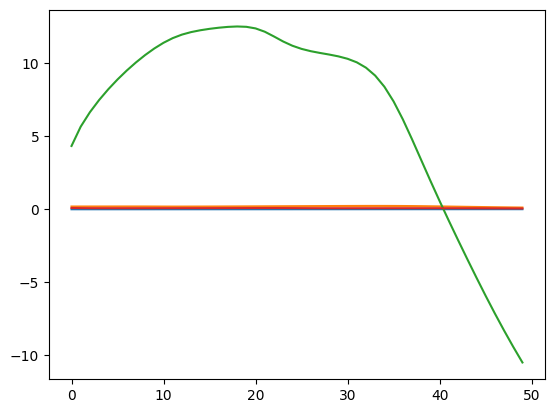

In [15]:
import matplotlib.pyplot as plt
import numpy as np

x = list(range(0,len(parameter_shift)))
plt.figure()

for i in range(4):
    plt.plot(x, [x[i] for x in parameter_shift] )

plt.show()